In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision matplotlib

Diffusion Model - The Structure¶
We can break down the process of Diffusion Model into two parts.

1. Forward Process
2. Reverse Process


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn
import math

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Forward diffusion**

#Diffusion models scale down the data with each forward process step (by a √ 1 − βt factor) so that variance does not grow when adding noise, thus providing consistently scaled inputs to the neural net reverse process.


The Forward Process gradually transforms the image into a Normal Distribution by introducing noise over T time steps.
The noise adds gradually according to the below Gaussian Distribution. Note that the noise is controlled by the parameter βt.


q
(
x
t
|
x
t
−
1
)
:=
N
(
x
t
;
√
(
1
−
β
t
)
x
t
−
1
,
β
t
I
)
 where
β
t
<
1
 for all
t

For forward process,
Time steps (T) = 1000

β1 = 10-4 and βT = 0.02

β is linearly scheduled which means
t = β1 + (βT x (t-1))/T
The interesting thing to note here is that given input image x0 and βt's, we can precompute all xt's at once. Check the math behind it here.

q
(
x
t
|
x
0
)
=
N
(
x
t
;
√
¯
α
t
x
0
,
(
1
−
¯
α
t
)
I
)

where
α
t
:=
1
−
β
t

¯
α
t
:=
t
∏
s
=
1

α
s

Using Reparameterization Trick; xt for all time steps can be computed using below formula.
x
t
=
√
¯
α
t
x
0
+
√
(
1
−
¯
α
t
)
ϵ





In [ ]:
def linear_scheduler(timesteps, start=0.0001, end=0.02):

    """
    Returns linear schedule for beta
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):

    """
    Returns values from vals for corresponding timesteps
    while considering the batch dimension.

    """
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it after adding noise t times.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_scheduler(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#**U-Net Architecture**

# U-Net Architecture is used to denoise the images and in the process learn the representations.

# 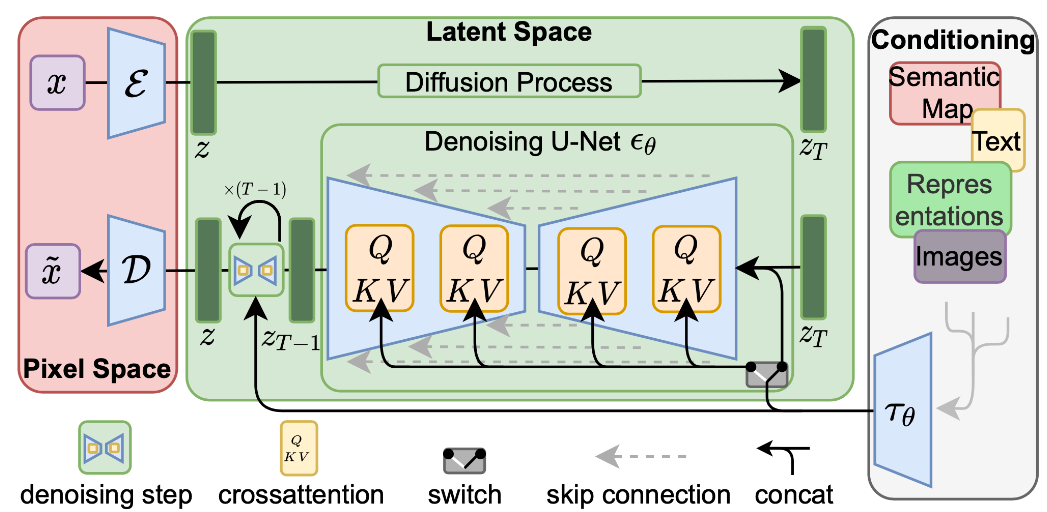

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):


        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class Unet(nn.Module):
    """
    A simplified Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )


        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1],
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):

        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = Unet()
model

Unet(
  (time_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256

#**Loss**

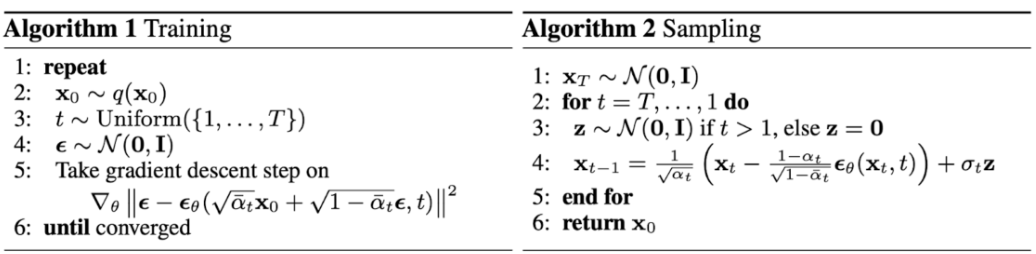

In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)



In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
# def sample_plot_image():
#     # Sample noise
#     img_size = IMG_SIZE
#     img = torch.randn((1, 3, img_size, img_size), device=device)
#     plt.figure(figsize=(15,15))
#     plt.axis('off')
#     num_images = 10
#     stepsize = int(T/num_images)

#     for i in range(0,T)[::-1]:
#         t = torch.full((1,), i, device=device, dtype=torch.long)
#         img = sample_timestep(img, t)
#         if i % stepsize == 0:
#             plt.subplot(1, num_images, i/stepsize+1)
#             show_tensor_image(img.detach().cpu())
#     plt.show()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    # Ensure integer index for subplot
    for i in range(0, T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        idx = i // stepsize  # Ensure the index is an integer
        plt.subplot(1, num_images, idx + 1)
        show_tensor_image(img.detach().cpu())

    plt.show()

## **Dataset**


In [ ]:
!pip install kaggle  # Install Kaggle API package

# Download dataset
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

# Unzip the dataset
import zipfile
with zipfile.ZipFile('stanford-cars-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('stanford_cars')


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset
License(s): other
 99% 1.82G/1.82G [00:20<00:00, 80.7MB/s]
100% 1.82G/1.82G [00:20<00:00, 95.2MB/s]


In [ ]:
!ls stanford_cars

cars_annos.mat	cars_test  cars_train


In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the path to the dataset
dataset_dir = '/content/stanford_cars/cars_train'  # Update this path if necessary

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load the StanfordCars dataset from the local directory
dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Example usage
for images, labels in dataloader:
    print(images.shape)  # Print the shape of the image tensor
    print(labels.shape)  # Print the shape of the labels tensor
    break  # Remove this break to iterate through the entire dataset


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 128, 128])
torch.Size([64])


In [ ]:
def show_images(data, num_images=4):
    images, labels = next(iter(data))
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert from (N, C, H, W) to (N, H, W, C)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] * 0.5 + 0.5))  # Undo normalization
        plt.axis('off')
    plt.show()


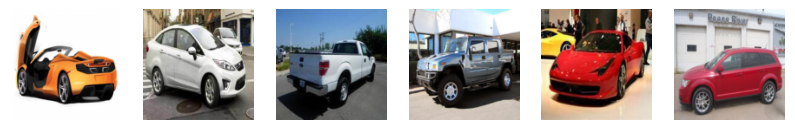

In [ ]:
show_images(dataloader, num_images=6)

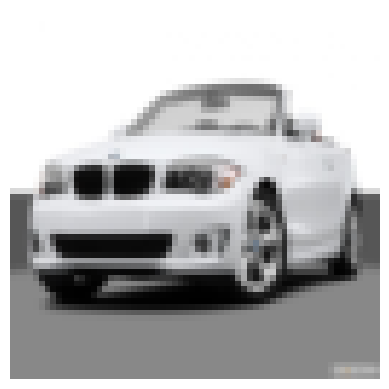

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import numpy as np
# import os

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    '''
    Returns data after applying appropriate transformations,
    to work with diffusion models.
    '''
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    # Define dataset directories
    train_dir = './stanford_cars/cars_train'
    test_dir = './stanford_cars/cars_test'

    # Load dataset using ImageFolder
    train = torchvision.datasets.ImageFolder(root=train_dir, transform=data_transform)
    test = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transform)

    # Concatenate train and test datasets
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    '''
    Plots image after applying reverse transformations.
    '''
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]  # Take the first image in the batch
    plt.imshow(reverse_transforms(image))
    plt.axis('off')  # Hide axes
    plt.show()

# Load dataset and create DataLoader
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Example usage
for images, labels in dataloader:
    show_tensor_image(images[0])  # Show the first image in the batch
    break  # Remove this break to iterate through the entire dataset


## **Sample Forward distribution**

<ipython-input-16-b86f0cf658b5>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)


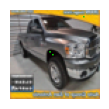

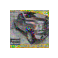

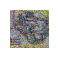

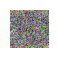

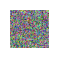

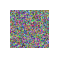

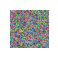

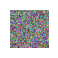

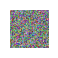

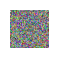

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assume forward_diffusion_sample and show_tensor_image are defined elsewhere

# Get a batch of images from the dataloader
image = next(iter(dataloader))[0]  # Get the first batch of images

# Create a figure for plotting
plt.figure(figsize=(15, 15))
plt.axis('off')

# Number of diffusion steps to visualize
num_images = 10
stepsize = int(T / num_images)  # Determine step size for visualization

# Iterate over diffusion steps to add noise progressively
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)  # Current timestep as a tensor
    # Define subplot index for horizontal arrangement
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    # Apply forward diffusion process to add noise
    image, noise = forward_diffusion_sample(image, t)
    # Show the image after diffusion step
    show_tensor_image(image)

# Display the plot with all subplots in a single horizontal row
plt.show()


#We can see that the noise being applied at every timestep is too aggresive and image quickly converges to pure noise.


**Training**

In [ ]:
import torch
from torch.optim import AdamW
import os

# Directory for checkpoints
checkpoint_dir = 'checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created directory {checkpoint_dir}")

# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, path)

# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        start_epoch = 0
        print("No checkpoint found. Starting training from scratch.")
    return start_epoch

# Move model to device
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Load checkpoint if available
start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

# Number of epochs
epochs = 100

# Training loop
for epoch in range(start_epoch, epochs):
    for step, batch in enumerate(dataloader):
        images, _ = batch
        images = images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Random time steps
        t = torch.randint(0, T, (images.size(0),), device=device).long()

        # Compute loss
        loss = get_loss(model, images, t)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Print and visualize every 5 epochs
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
            sample_plot_image()

    # Save checkpoint at the end of each epoch
    save_checkpoint(model, optimizer, epoch, loss.item(), checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}.")

# Save the final model state dictionary
torch.save(model.state_dict(), 'model.pth')
print("Final model state saved successfully.")


Output hidden; open in https://colab.research.google.com to view.

#Here the model need more epochs to train to completely denoise the image